# Testing JSBSim with PathSim

In this example JSBSim is used in conjunction with the [PathSim](https://pathsim.org/), a Python native system modeling library.

To run this example locally on your machine, make sure you create a Python environment with all the required dependencies. To learn more on PathSim, you can explore the GitHub pages:
- [https://github.com/pathsim](https://github.com/pathsim)
- [https://github.com/pathsim/pathsim](https://github.com/pathsim/pathsim)

## Initializing an FDM object

Instantiate an object `fdm` to prepare tthe simulation. Load the Global 5000 flight dynamics model (FDM): `global5000`. 

In [1]:
import os
import jsbsim
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Relative path to the directory where the flight model is stored
# Note - Aircraft directory needs to be writeable in order to modify the cg
PATH_TO_JSBSIM_FILES="../.."

print(f'=================================================================')
print(f'Current working directory: {os.getcwd()}')

# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="global5000"

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Instantiate the FDMExec object and load the aircraft
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

load_status = fdm.load_model(AIRCRAFT_NAME)

print(f'=================================================================')

Current working directory: f:\agodemar\jsbsim\examples\python


## Inspect the aircraft property tree and define some reference variable

In [2]:
ac_xml_tree = ET.parse(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
ac_xml_root = ac_xml_tree.getroot()

# Get the empty weight from aircraft xml [assume lbs]
for x in ac_xml_root.findall('mass_balance'):
        w = x.find('emptywt').text

empty_weight = float(w)

# Get the original CG from aircraft xml, assum inches from Construction axes origin
for loc in ac_xml_root.findall('mass_balance/location'):
        x_cg_ = loc.find('x').text

x_cg_0 = float(x_cg_)

# Assume a payload, midweight, lb
payload_0 = 15172/2

# Fuel max for Global5000, lbm
fuelmax = 8097.63

# Assume the mass of fuel, half tanks, lb
fuel_per_tank = fuelmax/2


# Select a speed to run the simulation at, knots
speed_cas = 250

# Assume a flight altitude
h_ft_0 = 15000

# Fuel max for Global5000, lbm
fuelmax = 8097.63

weight_0 = empty_weight + payload_0 + fuel_per_tank*3

# Assume a zero flight path angle, gamma_0
gamma_0 = 0

print("-----------------------------------------")
print("Altitude {} ft, Weight {} lb, CoG-x {} in".format(h_ft_0, weight_0, x_cg_0))
print("-----------------------------------------")
print("Running simulation at initial CAS = {} kn, and Altitude = {} ft".format(speed_cas, h_ft_0))
print("-----------------------------------------")

-----------------------------------------
Altitude 15000 ft, Weight 67967.445 lb, CoG-x 790.82 in
-----------------------------------------
Running simulation at initial CAS = 250 kn, and Altitude = 15000 ft
-----------------------------------------


## Perform a level-flight trim at the given altitude, and airspeed

In [3]:
# Set engines running
fdm['propulsion/set-running'] = -1
trim_results = []
trim_results_fcs = []

fdm['ic/h-sl-ft'] = h_ft_0
fdm['ic/vc-kts'] = speed_cas
fdm['ic/gamma-deg'] = gamma_0
fdm['propulsion/tank[0]/contents-lbs'] = fuel_per_tank
fdm['propulsion/tank[1]/contents-lbs'] = fuel_per_tank
fdm['propulsion/tank[2]/contents-lbs'] = fuel_per_tank
fdm['inertia/pointmass-weight-lbs[0]'] = payload_0

# Initialize the aircraft with initial conditions
fdm.run_ic()

# Run fdm model
fdm.run()

# Trim the aircraft to initial conditions
fdm['simulation/do_simple_trim'] = 1
fdm.run()

print("-----------------------------------------")

trim_results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
trim_results_fcs.append((fdm['fcs/elevator-pos-rad'], fdm['fcs/elevator-pos-deg'], fdm['fcs/elevator-pos-norm']))

# Print trim results
print("Trim results:")
print("CAS (knots): {}\nAoA (deg): {}".format(trim_results[0][0], trim_results[0][1]))
print("Elevator pos (rad): {}\nElevator pos (deg): {}\nElevator pos (norm): {}".format(trim_results_fcs[0][0], trim_results_fcs[0][1], trim_results_fcs[0][2]))
print("-----------------------------------------")

-----------------------------------------
Trim results:
CAS (knots): 249.99999925311056
AoA (deg): 4.317581190978358
Elevator pos (rad): -0.051721299163852034
Elevator pos (deg): -2.9634121530222353
Elevator pos (norm): -0.14777514046814869
-----------------------------------------


## Setting up PathSim objects

In [4]:
# -- Example Simulation --
# https://docs.pathsim.org/pathsim/

import numpy as np
from pathsim import Simulation, Connection
from pathsim.blocks import (
    DynamicalFunction, Source, StepSource, Adder, Scope
)

# An example of 'Dynamical function' that takes the elevator command as input and outputs the angle of attack
def f_aircraft(u, t):
    fdm["fcs/elevator-cmd-norm"] = u
    fdm.run()
    return fdm["aero/alpha-deg"]

dynFunAircraft = DynamicalFunction(f_aircraft)

# Constant signal function that outputs the elevator command (normalized) at trim
def f_elevator_command_at_trim(t):
    return trim_results_fcs[0][2]

# This source block will output the elevator command at trim, which is a constant signal
srcElevatorAtTrim = Source(f_elevator_command_at_trim)

# This step source will create a doublet input to the elevator command, which is a common test input in flight dynamics.
# The signal starts at 0, jumps to -0.1 at t=10 s, jumps to 0 at t=11 s, jumps to 0.1 at t=12 s, and returns to 0 at t=13 s
srcStepElevator = StepSource(amplitude=[-0.1, 0, 0.1, 0], tau=[10, 11, 12, 13])

# This adder block will sum the elevator command at trim and the step input to create the total elevator command input to the aircraft
addedElevatorSignals = Adder('++')

# Create a scope block to visualize the control input and the VCO output
sco = Scope(labels=["U1=Elevator Command Normalized (x100)", "Alpha (deg)"])

# This function will multiply the input signal u by a gain=100
def f_gain_100x(u, t):
    return 100.0 * u

# This dynamical function block will take the total elevator command and multiply it by 100 to amplify the signal for better visualization on the scope
ampElevatorNormalized = DynamicalFunction(f_gain_100x)

# Define blocks
blocks = [
    srcElevatorAtTrim, srcStepElevator, 
    addedElevatorSignals, dynFunAircraft, 
    ampElevatorNormalized,
    sco
]

# Define connections
connections = [
    Connection(srcElevatorAtTrim, addedElevatorSignals[0]),
    Connection(srcStepElevator, addedElevatorSignals[1]),
    Connection(addedElevatorSignals, dynFunAircraft),
    Connection(addedElevatorSignals, ampElevatorNormalized),
    Connection(ampElevatorNormalized, sco[0]),
    Connection(dynFunAircraft, sco[1])
]

# Initialize simulation
# Use a small time step (dt) to capture the 100 Hz oscillation
sim = Simulation(
    blocks, connections, 
    dt=1e-3, log=True)

print("Running simulation...")
sim.run(40.0)

12:05:28 - INFO - LOGGING (log: True)
12:05:28 - INFO - BLOCKS (total: 6, dynamic: 0, static: 6, eventful: 1)
12:05:28 - INFO - GRAPH (nodes: 6, edges: 6, alg. depth: 3, loop depth: 0, runtime: 0.046ms)
Running simulation...
12:05:28 - INFO - STARTING -> TRANSIENT (Duration: 40.00s)
12:05:29 - INFO - --------------------   1% | 0.1s<4.0s | 9998.8 it/s
12:05:29 - INFO - ####----------------  20% | 0.8s<2.7s | 11992.4 it/s
12:05:30 - INFO - ########------------  40% | 1.6s<2.4s | 10204.0 it/s
12:05:31 - INFO - ############--------  60% | 2.4s<1.5s | 10418.3 it/s
12:05:32 - INFO - ################----  80% | 3.3s<0.7s | 11591.2 it/s
12:05:33 - INFO - #################### 100% | 4.1s<--:-- | 11391.5 it/s
12:05:33 - INFO - FINISHED -> TRANSIENT (total steps: 40001, successful: 40001, runtime: 4081.02 ms)


{'total_steps': 40001,
 'successful_steps': 40001,
 'runtime_ms': 4081.0188000032213}

Scope recording_data shape: (40002, 2)
-----------------------------------------


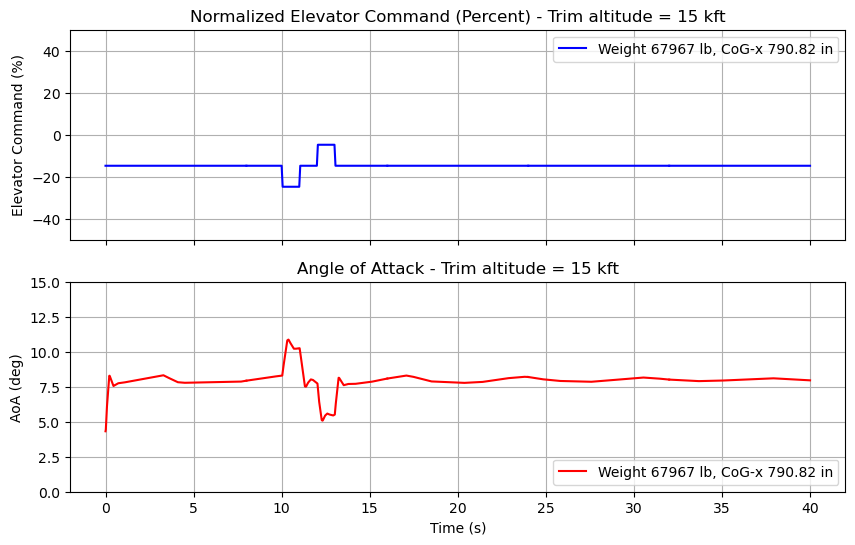

In [ ]:
%matplotlib inline
#sco.plot()
#plt.show()

print("Scope recording_data shape: {}".format(np.array(sco.recording_data[:]).shape))
print("-----------------------------------------")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(sco.recording_time, np.array(sco.recording_data[:])[:,0],
         label="Weight {0:.0f} lb, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         linestyle='-', color='blue')
ax1.set_title("Normalized Elevator Command (Percent) - Trim altitude = {0:.0f} kft".format(h_ft_0/1000))
ax1.set_ylabel('Elevator Command (%)')
ax1.grid()
ax1.set_ylim(-50, 50)
ax1.legend(loc='upper right')

ax2.plot(sco.recording_time, np.array(sco.recording_data[:])[:,1],
         label="Weight {0:.0f} lb, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         linestyle='-', color='red')
ax2.set_title("Angle of Attack - Trim altitude = {0:.0f} kft".format(h_ft_0/1000))
ax2.legend(loc='lower right')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('AoA (deg)')
ax2.grid()
ax2.set_ylim(0, 15)

plt.show()